In [1]:
%load_ext autoreload
%autoreload 2
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms

### Collect data

In [4]:
DATASET_ID = 'macaque_coo'

In [5]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [6]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'macaque.pickle'

In [7]:
syllable_df = pd.read_pickle(df_loc)

In [8]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,audio,rate,spectrogram
0,0.0,0.576841,QU,0,QU961,"[-1.5382879036171296e-05, -0.00013294855745331...",24414,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,0.0,0.070544,SN,0,SN961,"[-6.30847800886783e-07, -6.1899308990145226e-0...",44100,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
0,0.0,0.474031,QU,0,QU479,"[3.997810370982371e-06, 3.1708158648103554e-05...",24414,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


### cluster

In [9]:
specs = list(syllable_df.spectrogram.values)
specs = [i / np.max(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(7285, 864)

In [10]:
from cuml.manifold.umap import UMAP as cumlUMAP

In [11]:
cuml_umap = cumlUMAP()
z = np.vstack(list(cuml_umap.fit_transform(specs_flattened)))

### variation across populations

{'AL': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765), 'BE': (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), 'IO': (1.0, 0.4980392156862745, 0.054901960784313725), 'MU': (1.0, 0.7333333333333333, 0.47058823529411764), 'QU': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313), 'SN': (0.596078431372549, 0.8745098039215686, 0.5411764705882353), 'TH': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392), 'TW': (1.0, 0.596078431372549, 0.5882352941176471)}


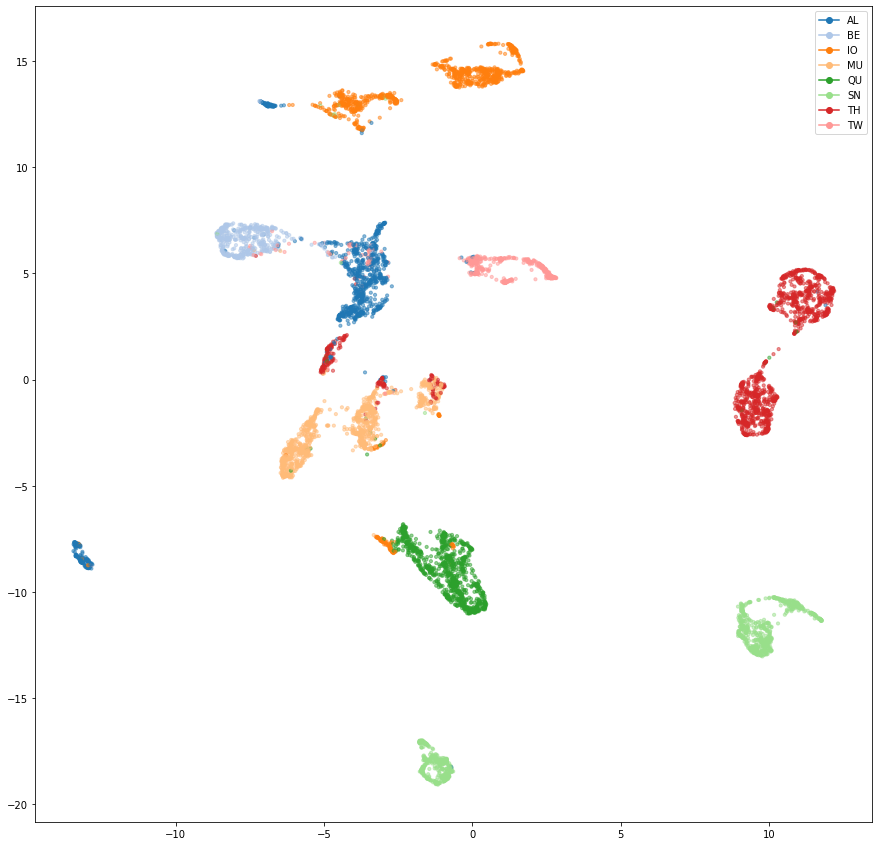

In [12]:
fig, ax = plt.subplots(figsize=(15,15))
scatter_projections(projection=z, alpha=.5, labels = syllable_df.indv.values, s=10, ax = ax)
#ax.set_xlim([-15,15])

In [13]:
from avgn.visualization.projections import scatter_spec

In [14]:
np.shape(z), np.shape(specs)

((7285, 2), (7285, 32, 27))

In [15]:
from avgn.utils.general import save_fig
from avgn.utils.paths import FIGURE_DIR, ensure_dir

{'AL': (0.4, 0.7607843137254902, 0.6470588235294118), 'BE': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961), 'IO': (0.5529411764705883, 0.6274509803921569, 0.796078431372549), 'MU': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411), 'QU': (0.6509803921568628, 0.8470588235294118, 0.32941176470588235), 'SN': (1.0, 0.8509803921568627, 0.1843137254901961), 'TH': (0.8980392156862745, 0.7686274509803922, 0.5803921568627451), 'TW': (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)}


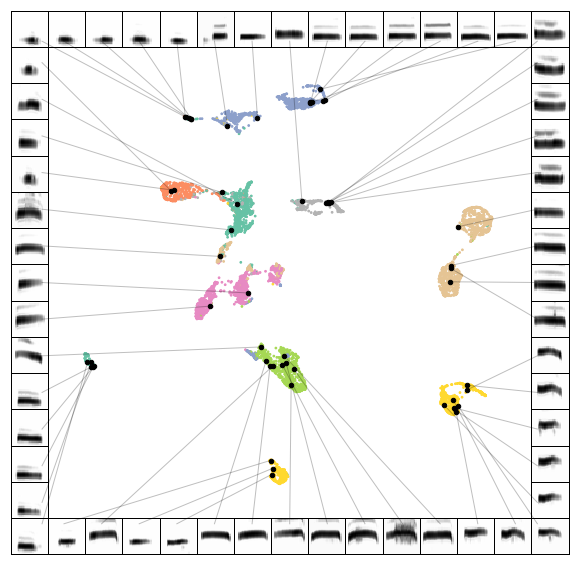

In [16]:
scatter_spec(
    z,
    specs,
    column_size=15,
    #x_range = [-5.5,7],
    #y_range = [-10,10],
    pal_color="hls",
    color_points=False,
    enlarge_points=20,
    figsize=(10, 10),
    scatter_kwargs = {
        'labels': syllable_df.indv.values,
        'alpha':1.0,
        's': 3,
        "color_palette": 'Set2',
        'show_legend': False
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':1,
        'ls':"solid",
        'alpha':0.25,
    },
    draw_lines=True
);
#save_fig(FIGURE_DIR / 'macaque_coo', dpi=300, save_jpg=True)

{'AL': (0.8941176470588236, 0.10196078431372549, 0.10980392156862745), 'BE': (0.21568627450980393, 0.49411764705882355, 0.7215686274509804), 'IO': (0.30196078431372547, 0.6862745098039216, 0.2901960784313726), 'MU': (0.596078431372549, 0.3058823529411765, 0.6392156862745098), 'QU': (1.0, 0.4980392156862745, 0.0), 'SN': (1.0, 1.0, 0.2), 'TH': (0.6509803921568628, 0.33725490196078434, 0.1568627450980392), 'TW': (0.9686274509803922, 0.5058823529411764, 0.7490196078431373)}


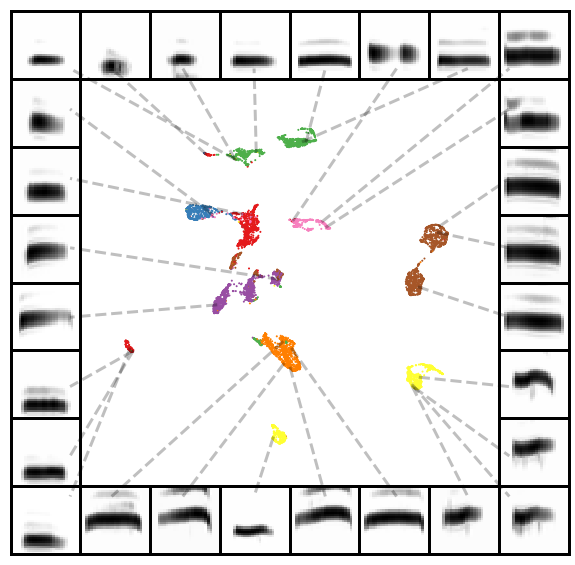

In [17]:
nex = -1
scatter_spec(
    z,
    specs,
    column_size=8,
    #x_range = [-4.5,4],
    #y_range = [-4.5,5.5],
    pal_color="hls",
    color_points=False,
    enlarge_points=0,
    figsize=(10, 10),
    range_pad = 0.15,
    scatter_kwargs = {
        'labels': syllable_df.indv.values,
        'alpha':1,
        's': 1,
        'show_legend': False,
        "color_palette": 'Set1',
    },
    matshow_kwargs = {
        'cmap': plt.cm.Greys
    },
    line_kwargs = {
        'lw':3,
        'ls':"dashed",
        'alpha':0.25,
    },
    draw_lines=True,
    n_subset= 1000,
    border_line_width = 3,

);
#save_fig(FIGURE_DIR / 'discrete_umap' / 'indv' / 'macaque', dpi=300, save_jpg=True, save_png=True)

### get silhouette score

In [18]:
from sklearn.metrics import silhouette_score

In [19]:
score = silhouette_score(list(z), labels = syllable_df.indv.values)

In [20]:
print(score)

0.3783766546718139
